# **Notebook setup and imports**

In [2]:
import argparse
import numpy as np
import pandas as pd
import os
from types import SimpleNamespace
import pickle
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2

import mvtec

In [3]:
# device setup
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [4]:
args = SimpleNamespace(
    data_path='/kaggle/input/mvtec-ad',
    save_path='/kaggle/working/mvtec_result',
    class_name='bottle', 
    phase='train',
    top_k=5
)

In [5]:
os.makedirs(args.save_path, exist_ok=True)

# **Functions**

In [6]:
def denormalization(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)
    return x

In [7]:
def calc_dist_matrix(x, y):
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    dist_matrix = torch.sqrt(torch.pow(x - y, 2).sum(2))
    return dist_matrix

In [8]:
def visualize_loc_result(test_imgs, gt_mask_list, score_map_list, threshold,
                         save_path, class_name, vis_num=5):

    for t_idx in range(vis_num):
        test_img = test_imgs[t_idx]
        test_img = denormalization(test_img)
        test_gt = gt_mask_list[t_idx].transpose(1, 2, 0).squeeze()
        test_pred = score_map_list[t_idx]
        test_pred[test_pred <= threshold] = 0
        test_pred[test_pred > threshold] = 1
        test_pred_img = test_img.copy()
        test_pred_img[test_pred == 0] = 0

        fig_img, ax_img = plt.subplots(1, 4, figsize=(12, 4))
        fig_img.subplots_adjust(left=0, right=1, bottom=0, top=1)

        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)

        ax_img[0].imshow(test_img)
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(test_gt, cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax_img[2].imshow(test_pred, cmap='gray')
        ax_img[2].title.set_text('Predicted mask')
        ax_img[3].imshow(test_pred_img)
        ax_img[3].title.set_text('Predicted anomalous image')

        os.makedirs(os.path.join(save_path, 'images'), exist_ok=True)
        fig_img.savefig(os.path.join(save_path, 'images', '%s_%03d.png' % (class_name, t_idx)), dpi=100)
        fig_img.clf()
        plt.close(fig_img)

# **SPADE**

In [9]:
def main():
    global args
    model = wide_resnet50_2(pretrained=True, progress=True)
    model.to(device)
    model.eval()

    outputs = []
    def hook(module, input, output):
        outputs.append(output)
    model.layer1[-1].register_forward_hook(hook)
    model.layer2[-1].register_forward_hook(hook)
    model.layer3[-1].register_forward_hook(hook)
    model.avgpool.register_forward_hook(hook)

    os.makedirs(os.path.join(args.save_path, 'temp'), exist_ok=True)

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    fig_img_rocauc = ax[0]
    fig_pixel_rocauc = ax[1]

    total_roc_auc = []
    total_pixel_roc_auc = []

    for class_name in mvtec.CLASS_NAMES:

        train_dataset = mvtec.MVTecDataset(args.data_path, class_name=class_name, is_train=True)
        train_dataloader = DataLoader(train_dataset, batch_size=32, pin_memory=True)
        test_dataset = mvtec.MVTecDataset(args.data_path, class_name=class_name, is_train=False)
        test_dataloader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

        train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', []), ('avgpool', [])])
        test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', []), ('avgpool', [])])

        # extract train set features
        train_feature_filepath = os.path.join(args.save_path, 'temp', 'train_%s.pkl' % class_name)
        if not os.path.exists(train_feature_filepath):
            for (x, y, mask) in tqdm(train_dataloader, '| feature extraction | train | %s |' % class_name):
                with torch.no_grad():
                    pred = model(x.to(device))
                for k, v in zip(train_outputs.keys(), outputs):
                    train_outputs[k].append(v)
                outputs = []
            for k, v in train_outputs.items():
                train_outputs[k] = torch.cat(v, 0)
            with open(train_feature_filepath, 'wb') as f:
                pickle.dump(train_outputs, f)
                
            if 'avgpool' in train_outputs:
                feature_tensor = train_outputs['avgpool']
                feature_tensor = torch.flatten(feature_tensor, 1).cpu().numpy()
                df = pd.DataFrame(feature_tensor)
                csv_path = os.path.join(args.save_path, 'temp', f'avgpool_features_{class_name}.csv')
                df.to_csv(csv_path, index=False)
                print(f"Saved avgpool features for class '{class_name}' to {csv_path}")
            else:
                print("No 'avgpool' features found in train_outputs.")
        else:
            print('load train set feature from: %s' % train_feature_filepath)
            with open(train_feature_filepath, 'rb') as f:
                train_outputs = pickle.load(f)

        gt_list = []
        gt_mask_list = []
        test_imgs = []

        # extract test set features
        for (x, y, mask) in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
            test_imgs.extend(x.cpu().detach().numpy())
            gt_list.extend(y.cpu().detach().numpy())
            gt_mask_list.extend(mask.cpu().detach().numpy())
            with torch.no_grad():
                pred = model(x.to(device))
            for k, v in zip(test_outputs.keys(), outputs):
                test_outputs[k].append(v)
            outputs = []
        for k, v in test_outputs.items():
            test_outputs[k] = torch.cat(v, 0)

        # calculate distance matrix
        dist_matrix = calc_dist_matrix(torch.flatten(test_outputs['avgpool'], 1),
                                       torch.flatten(train_outputs['avgpool'], 1))

        # select K nearest neighbor and take average
        topk_values, topk_indexes = torch.topk(dist_matrix, k=args.top_k, dim=1, largest=False)
        scores = torch.mean(topk_values, 1).cpu().detach().numpy()

        # calculate image-level ROC AUC score
        fpr, tpr, _ = roc_curve(gt_list, scores)
        roc_auc = roc_auc_score(gt_list, scores)
        total_roc_auc.append(roc_auc)
        print('%s ROCAUC: %.3f' % (class_name, roc_auc))
        fig_img_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (class_name, roc_auc))

        score_map_list = []
        for t_idx in tqdm(range(test_outputs['avgpool'].shape[0]), '| localization | test | %s |' % class_name):
            score_maps = []
            for layer_name in ['layer1', 'layer2', 'layer3']: 
                topk_feat_map = train_outputs[layer_name][topk_indexes[t_idx]]
                test_feat_map = test_outputs[layer_name][t_idx:t_idx + 1]
                feat_gallery = topk_feat_map.transpose(3, 1).flatten(0, 2).unsqueeze(-1).unsqueeze(-1)

                dist_matrix_list = []
                for d_idx in range(feat_gallery.shape[0] // 100):
                    dist_matrix = torch.pairwise_distance(feat_gallery[d_idx * 100:d_idx * 100 + 100], test_feat_map)
                    dist_matrix_list.append(dist_matrix)
                dist_matrix = torch.cat(dist_matrix_list, 0)

                score_map = torch.min(dist_matrix, dim=0)[0]
                score_map = F.interpolate(score_map.unsqueeze(0).unsqueeze(0), size=224,
                                          mode='bilinear', align_corners=False)
                score_maps.append(score_map)

            # average distance between the features
            score_map = torch.mean(torch.cat(score_maps, 0), dim=0)

            # apply gaussian smoothing on the score map
            score_map = gaussian_filter(score_map.squeeze().cpu().detach().numpy(), sigma=4)
            score_map_list.append(score_map)

        flatten_gt_mask_list = np.concatenate(gt_mask_list).ravel()
        flatten_score_map_list = np.concatenate(score_map_list).ravel()

        # calculate per-pixel level ROCAUC
        fpr, tpr, _ = roc_curve(flatten_gt_mask_list, flatten_score_map_list)
        per_pixel_rocauc = roc_auc_score(flatten_gt_mask_list, flatten_score_map_list)
        total_pixel_roc_auc.append(per_pixel_rocauc)
        print('%s pixel ROCAUC: %.3f' % (class_name, per_pixel_rocauc))
        fig_pixel_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (class_name, per_pixel_rocauc))

        # get optimal threshold
        precision, recall, thresholds = precision_recall_curve(flatten_gt_mask_list, flatten_score_map_list)
        a = 2 * precision * recall
        b = precision + recall
        f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
        threshold = thresholds[np.argmax(f1)]

        # visualize localization result
        visualize_loc_result(test_imgs, gt_mask_list, score_map_list, threshold, args.save_path, class_name, vis_num=5)

    print('Average ROCAUC: %.3f' % np.mean(total_roc_auc))
    fig_img_rocauc.title.set_text('Average image ROCAUC: %.3f' % np.mean(total_roc_auc))
    fig_img_rocauc.legend(loc="lower right")

    print('Average pixel ROCUAC: %.3f' % np.mean(total_pixel_roc_auc))
    fig_pixel_rocauc.title.set_text('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
    fig_pixel_rocauc.legend(loc="lower right")

    fig.tight_layout()
    fig.savefig(os.path.join(args.save_path, 'roc_curve.png'), dpi=100)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 175MB/s] 
| feature extraction | train | bottle |: 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


Saved avgpool features for class 'bottle' to /kaggle/working/mvtec_result/temp/avgpool_features_bottle.csv


| feature extraction | test | bottle |: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


bottle ROCAUC: 0.972


| localization | test | bottle |: 100%|██████████| 83/83 [01:52<00:00,  1.36s/it]


bottle pixel ROCAUC: 0.562


| feature extraction | train | cable |: 100%|██████████| 7/7 [00:15<00:00,  2.19s/it]


Saved avgpool features for class 'cable' to /kaggle/working/mvtec_result/temp/avgpool_features_cable.csv


| feature extraction | test | cable |: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


cable ROCAUC: 0.848


| localization | test | cable |: 100%|██████████| 150/150 [03:28<00:00,  1.39s/it]


cable pixel ROCAUC: 0.654


| feature extraction | train | capsule |: 100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


Saved avgpool features for class 'capsule' to /kaggle/working/mvtec_result/temp/avgpool_features_capsule.csv


| feature extraction | test | capsule |: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


capsule ROCAUC: 0.897


| localization | test | capsule |: 100%|██████████| 132/132 [03:03<00:00,  1.39s/it]


capsule pixel ROCAUC: 0.638


| feature extraction | train | carpet |: 100%|██████████| 9/9 [00:21<00:00,  2.34s/it]


Saved avgpool features for class 'carpet' to /kaggle/working/mvtec_result/temp/avgpool_features_carpet.csv


| feature extraction | test | carpet |: 100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


carpet ROCAUC: 0.928


| localization | test | carpet |: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it]


carpet pixel ROCAUC: 0.663


| feature extraction | train | grid |: 100%|██████████| 9/9 [00:10<00:00,  1.21s/it]


Saved avgpool features for class 'grid' to /kaggle/working/mvtec_result/temp/avgpool_features_grid.csv


| feature extraction | test | grid |: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


grid ROCAUC: 0.473


| localization | test | grid |: 100%|██████████| 78/78 [01:48<00:00,  1.39s/it]


grid pixel ROCAUC: 0.566


| feature extraction | train | hazelnut |: 100%|██████████| 13/13 [00:27<00:00,  2.09s/it]


Saved avgpool features for class 'hazelnut' to /kaggle/working/mvtec_result/temp/avgpool_features_hazelnut.csv


| feature extraction | test | hazelnut |: 100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


hazelnut ROCAUC: 0.881


| localization | test | hazelnut |: 100%|██████████| 110/110 [02:33<00:00,  1.39s/it]


hazelnut pixel ROCAUC: 0.830


| feature extraction | train | leather |: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it]


Saved avgpool features for class 'leather' to /kaggle/working/mvtec_result/temp/avgpool_features_leather.csv


| feature extraction | test | leather |: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


leather ROCAUC: 0.954


| localization | test | leather |: 100%|██████████| 124/124 [02:52<00:00,  1.39s/it]


leather pixel ROCAUC: 0.615


| feature extraction | train | metal_nut |: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Saved avgpool features for class 'metal_nut' to /kaggle/working/mvtec_result/temp/avgpool_features_metal_nut.csv


| feature extraction | test | metal_nut |: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


metal_nut ROCAUC: 0.710


| localization | test | metal_nut |: 100%|██████████| 115/115 [02:40<00:00,  1.39s/it]


metal_nut pixel ROCAUC: 0.509


| feature extraction | train | pill |: 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


Saved avgpool features for class 'pill' to /kaggle/working/mvtec_result/temp/avgpool_features_pill.csv


| feature extraction | test | pill |: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


pill ROCAUC: 0.801


| localization | test | pill |: 100%|██████████| 167/167 [03:52<00:00,  1.39s/it]


pill pixel ROCAUC: 0.647


| feature extraction | train | screw |: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Saved avgpool features for class 'screw' to /kaggle/working/mvtec_result/temp/avgpool_features_screw.csv


| feature extraction | test | screw |: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


screw ROCAUC: 0.667


| localization | test | screw |: 100%|██████████| 160/160 [03:42<00:00,  1.39s/it]


screw pixel ROCAUC: 0.583


| feature extraction | train | tile |: 100%|██████████| 8/8 [00:13<00:00,  1.68s/it]


Saved avgpool features for class 'tile' to /kaggle/working/mvtec_result/temp/avgpool_features_tile.csv


| feature extraction | test | tile |: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


tile ROCAUC: 0.965


| localization | test | tile |: 100%|██████████| 117/117 [02:42<00:00,  1.39s/it]


tile pixel ROCAUC: 0.632


| feature extraction | train | toothbrush |: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


Saved avgpool features for class 'toothbrush' to /kaggle/working/mvtec_result/temp/avgpool_features_toothbrush.csv


| feature extraction | test | toothbrush |: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


toothbrush ROCAUC: 0.889


| localization | test | toothbrush |: 100%|██████████| 42/42 [00:58<00:00,  1.40s/it]


toothbrush pixel ROCAUC: 0.568


| feature extraction | train | transistor |: 100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


Saved avgpool features for class 'transistor' to /kaggle/working/mvtec_result/temp/avgpool_features_transistor.csv


| feature extraction | test | transistor |: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


transistor ROCAUC: 0.903


| localization | test | transistor |: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


transistor pixel ROCAUC: 0.507


| feature extraction | train | wood |: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it]


Saved avgpool features for class 'wood' to /kaggle/working/mvtec_result/temp/avgpool_features_wood.csv


| feature extraction | test | wood |: 100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


wood ROCAUC: 0.958


| localization | test | wood |: 100%|██████████| 79/79 [01:49<00:00,  1.39s/it]


wood pixel ROCAUC: 0.644


| feature extraction | train | zipper |: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


Saved avgpool features for class 'zipper' to /kaggle/working/mvtec_result/temp/avgpool_features_zipper.csv


| feature extraction | test | zipper |: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


zipper ROCAUC: 0.966


| localization | test | zipper |: 100%|██████████| 151/151 [03:30<00:00,  1.39s/it]


zipper pixel ROCAUC: 0.415
Average ROCAUC: 0.854
Average pixel ROCUAC: 0.602


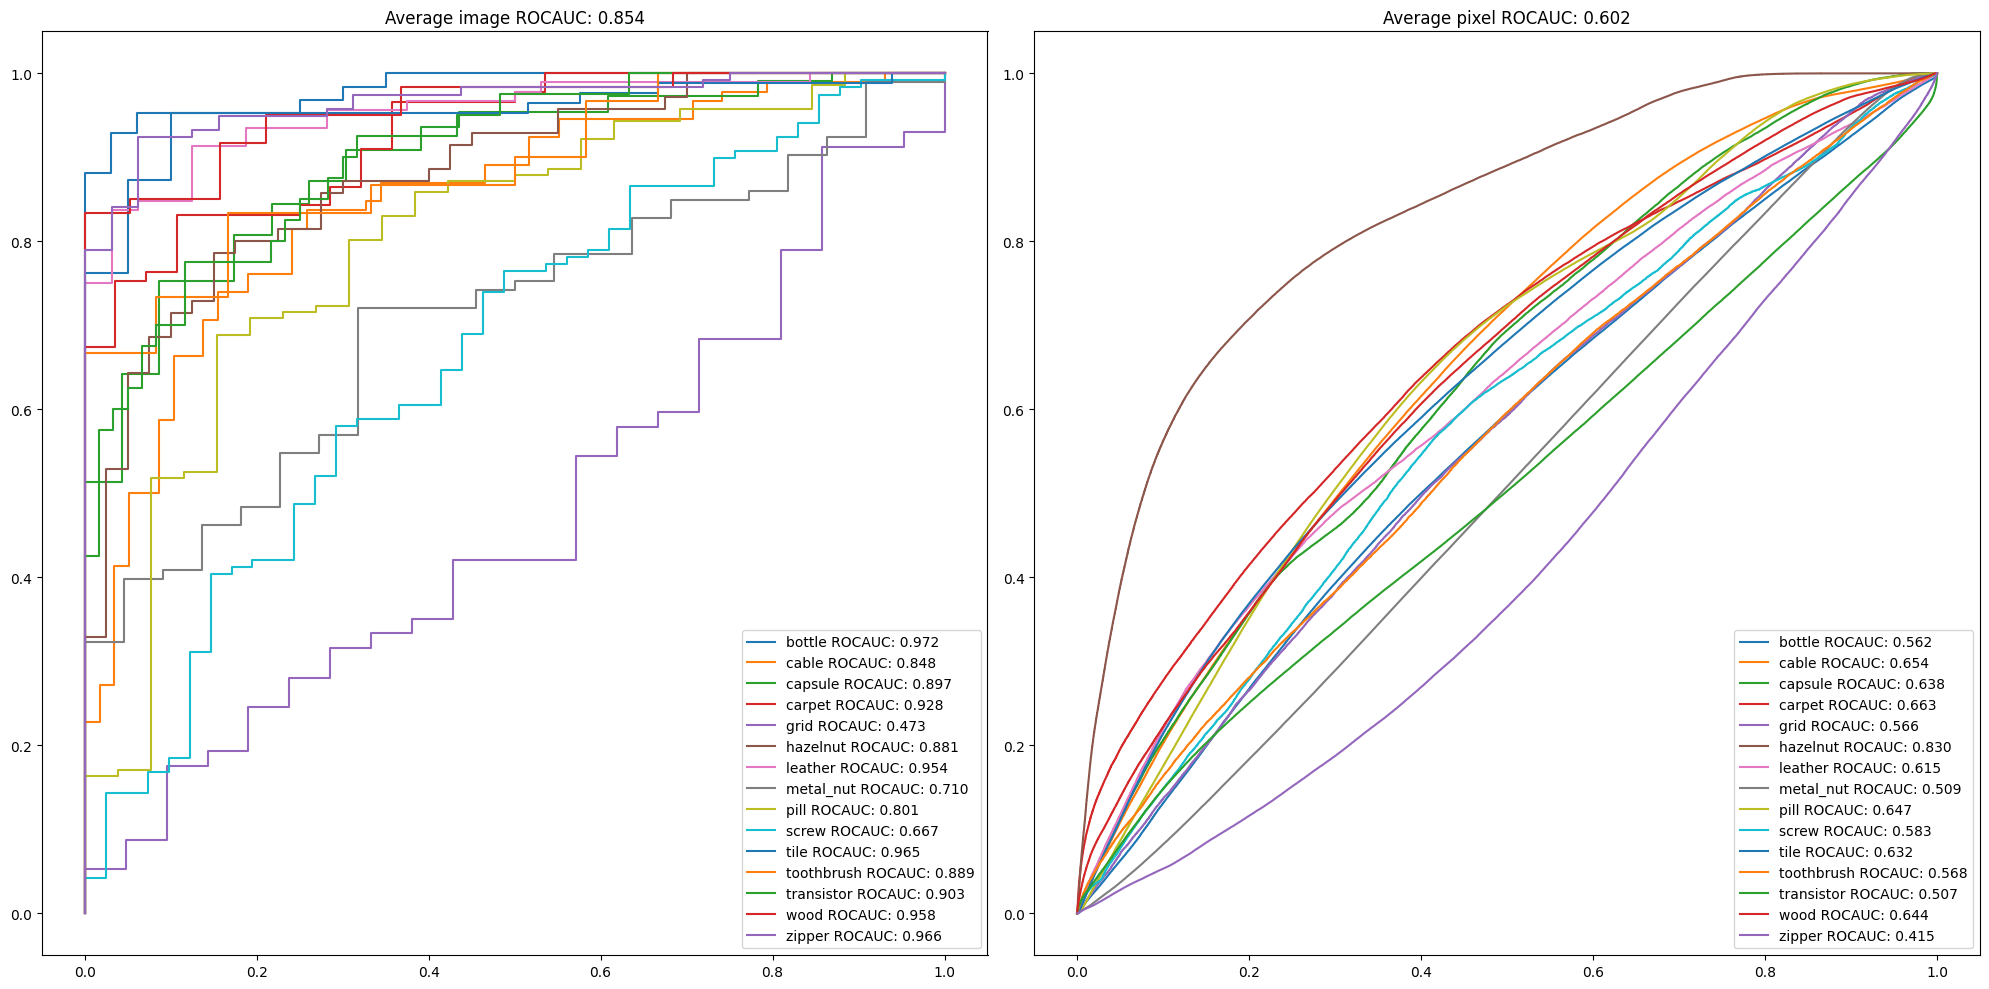

In [10]:
main()